<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_21_40_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [70]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [71]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [72]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [73]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [74]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [75]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            # nn.Flatten(),
            # nn.LazyLinear(10),
            nn.Conv2d(1, 10, kernel_size=3, padding=1, stride=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 5, kernel_size=3, padding=1, stride=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(5),
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [76]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [77]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [ ]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 15

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [79]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [80]:
from torchsummary import summary
model = Module().to(device)
summary(model, (1, 28, 28))

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 14, 14]             100
         MaxPool2d-2             [-1, 10, 7, 7]               0
              ReLU-3             [-1, 10, 7, 7]               0
       BatchNorm2d-4             [-1, 10, 7, 7]              20
            Conv2d-5              [-1, 5, 4, 4]             455
         MaxPool2d-6              [-1, 5, 2, 2]               0
              ReLU-7              [-1, 5, 2, 2]               0
       BatchNorm2d-8              [-1, 5, 2, 2]              10
           Flatten-9                   [-1, 20]               0
           Linear-10                   [-1, 10]             210
Total params: 795
Trainable params: 795
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Siz

 - Task 0

Accuracy 0.3706
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.64      0.56      0.60       980
     1 - one       0.15      0.04      0.06      1135
     2 - two       0.50      0.28      0.35      1032
   3 - three       0.31      0.32      0.31      1010
    4 - four       0.15      0.45      0.23       982
    5 - five       0.47      0.20      0.28       892
     6 - six       0.46      0.66      0.54       958
   7 - seven       0.50      0.70      0.59      1028
   8 - eight       0.20      0.05      0.08       974
    9 - nine       0.52      0.49      0.51      1009

    accuracy                           0.37     10000
   macro avg       0.39      0.37      0.35     10000
weighted avg       0.39      0.37      0.35     10000



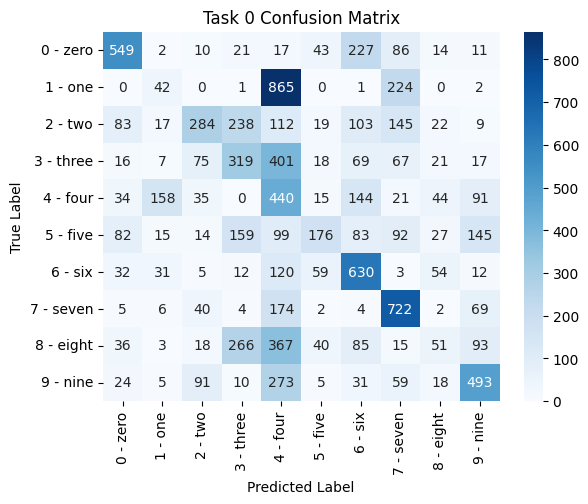

In [81]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.6572
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.83      0.84      0.84       980
     1 - one       0.82      0.90      0.86      1135
     2 - two       0.67      0.56      0.61      1032
   3 - three       0.55      0.50      0.52      1010
    4 - four       0.62      0.63      0.63       982
    5 - five       0.60      0.53      0.56       892
     6 - six       0.69      0.69      0.69       958
   7 - seven       0.63      0.70      0.66      1028
   8 - eight       0.51      0.57      0.54       974
    9 - nine       0.60      0.63      0.61      1009

    accuracy                           0.66     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.66      0.66      0.66     10000



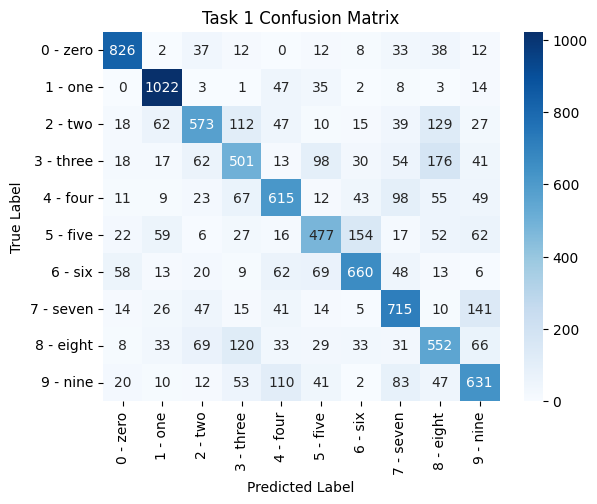

In [82]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.0.weight
torch.Size([10, 1, 3, 3])
Max fisher is 0.14758 and it's parameter diff is 0.03936
Min Parameter diff is 0.23842 and it's fisher is 0.02355
fisher > parameter diff: 4
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

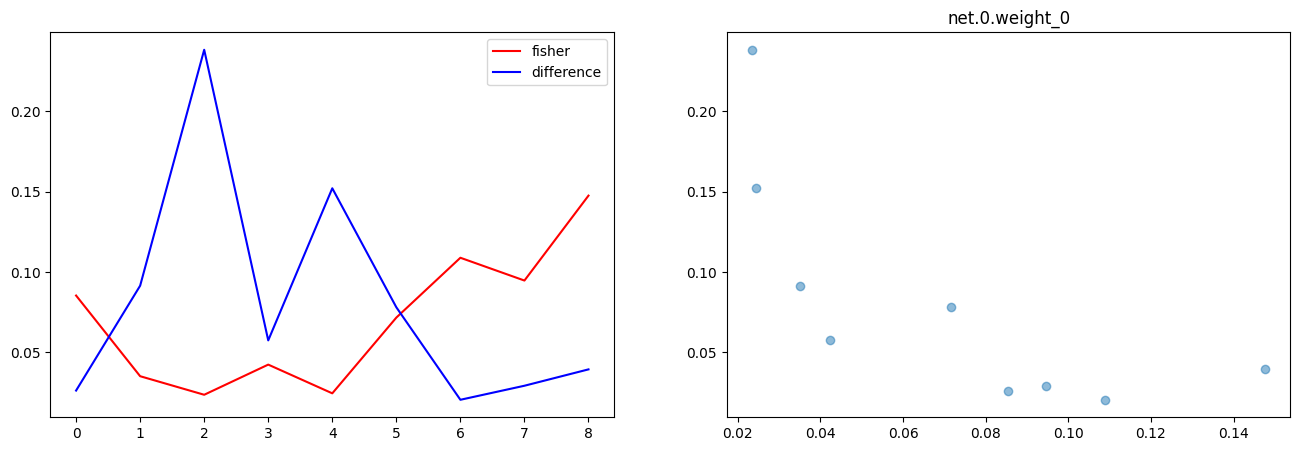

Max fisher is 4.57233 and it's parameter diff is 0.00010
Min Parameter diff is 0.01713 and it's fisher is 0.06864
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

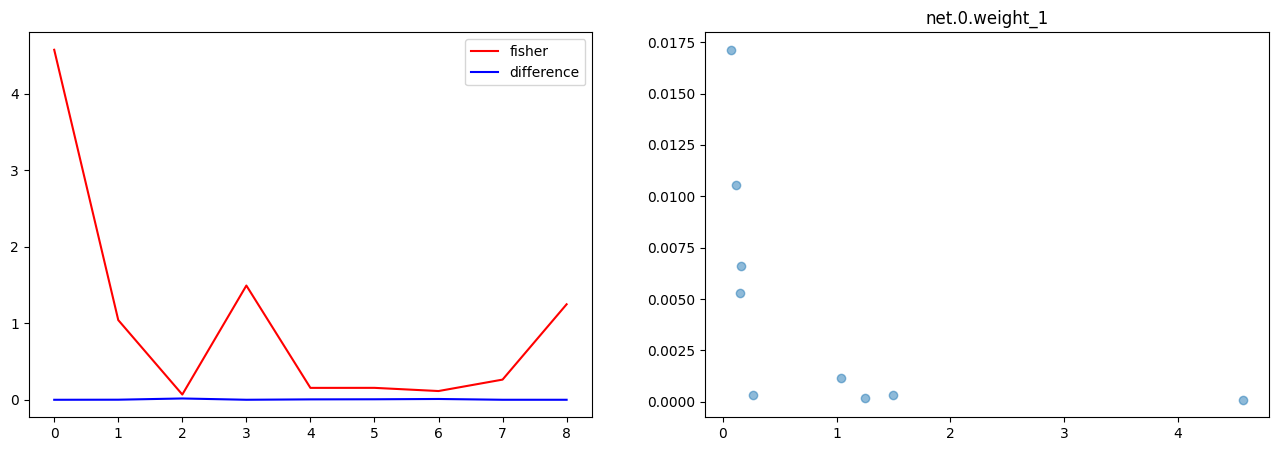

Max fisher is 0.61857 and it's parameter diff is 0.00226
Min Parameter diff is 0.27308 and it's fisher is 0.00443
fisher > parameter diff: 5
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

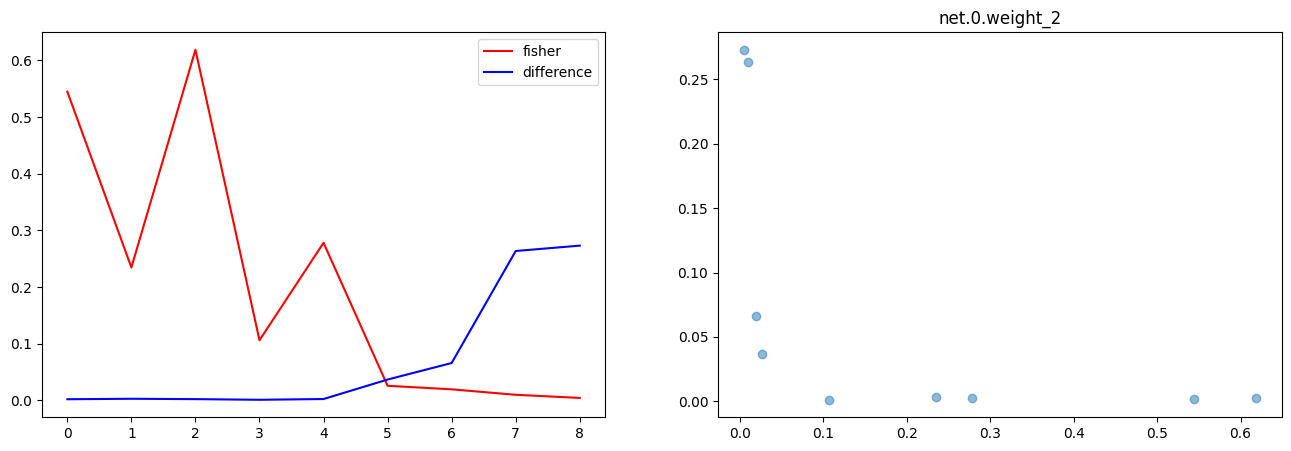

Max fisher is 0.49781 and it's parameter diff is 0.00386
Min Parameter diff is 0.01727 and it's fisher is 0.06159
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

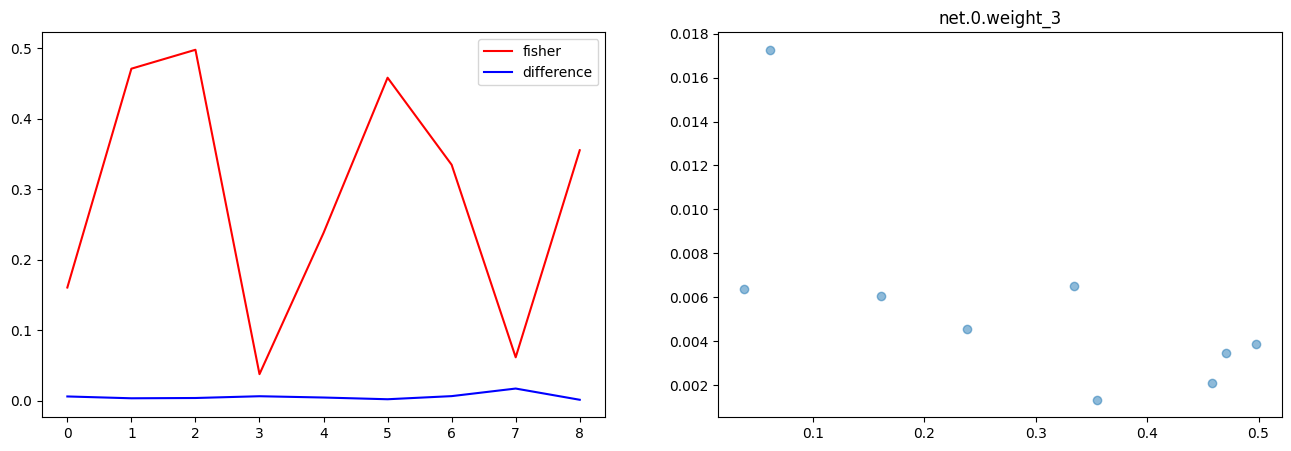

Max fisher is 0.11395 and it's parameter diff is 0.01651
Min Parameter diff is 0.10754 and it's fisher is 0.00249
fisher > parameter diff: 5
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

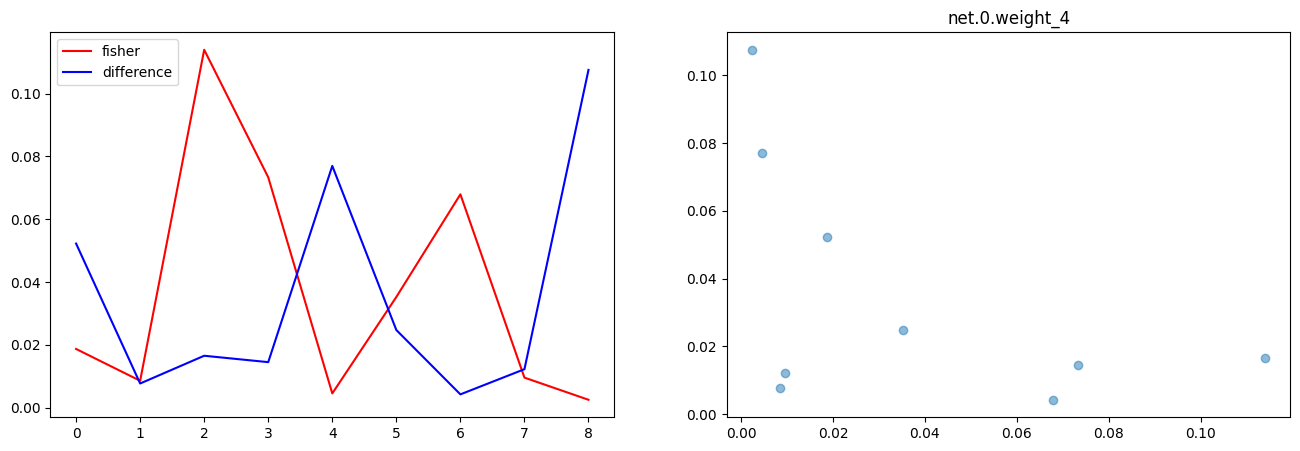

Max fisher is 0.24069 and it's parameter diff is 0.02188
Min Parameter diff is 0.37901 and it's fisher is 0.01770
fisher > parameter diff: 4
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

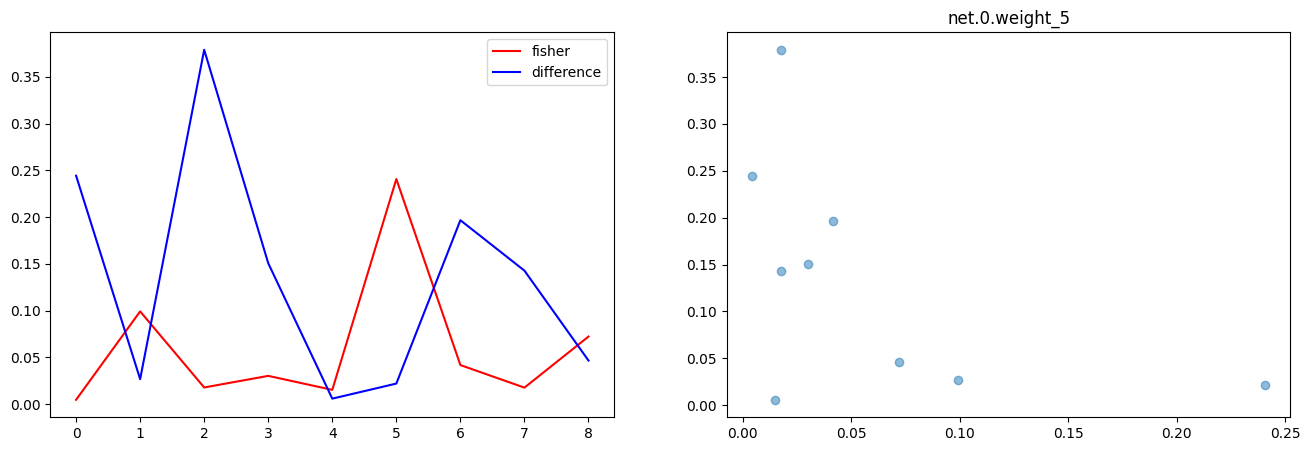

Max fisher is 0.56885 and it's parameter diff is 0.01945
Min Parameter diff is 0.42575 and it's fisher is 0.01110
fisher > parameter diff: 5
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

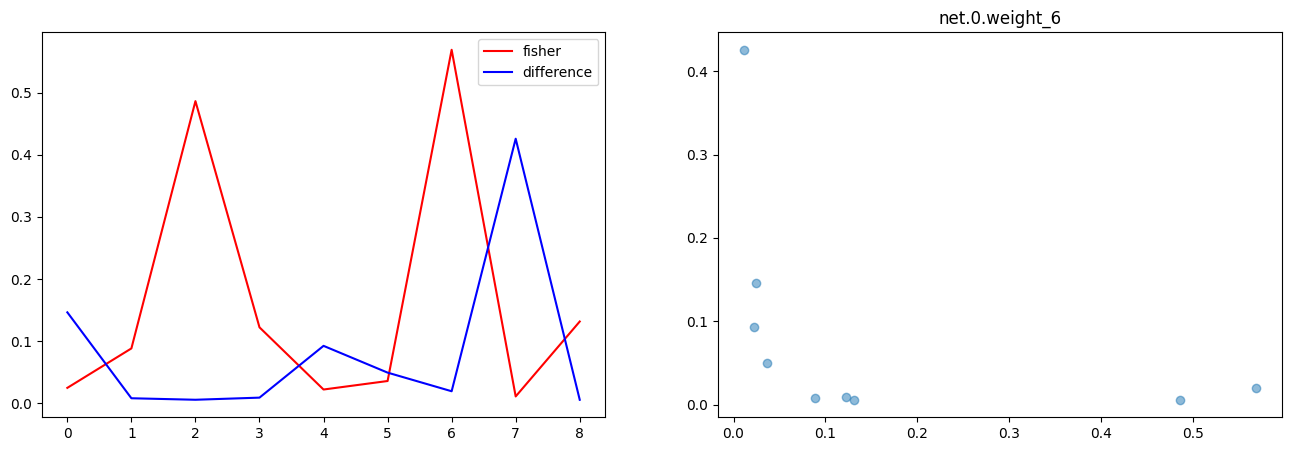

Max fisher is 2.89073 and it's parameter diff is 0.00170
Min Parameter diff is 0.12466 and it's fisher is 0.02877
fisher > parameter diff: 8
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

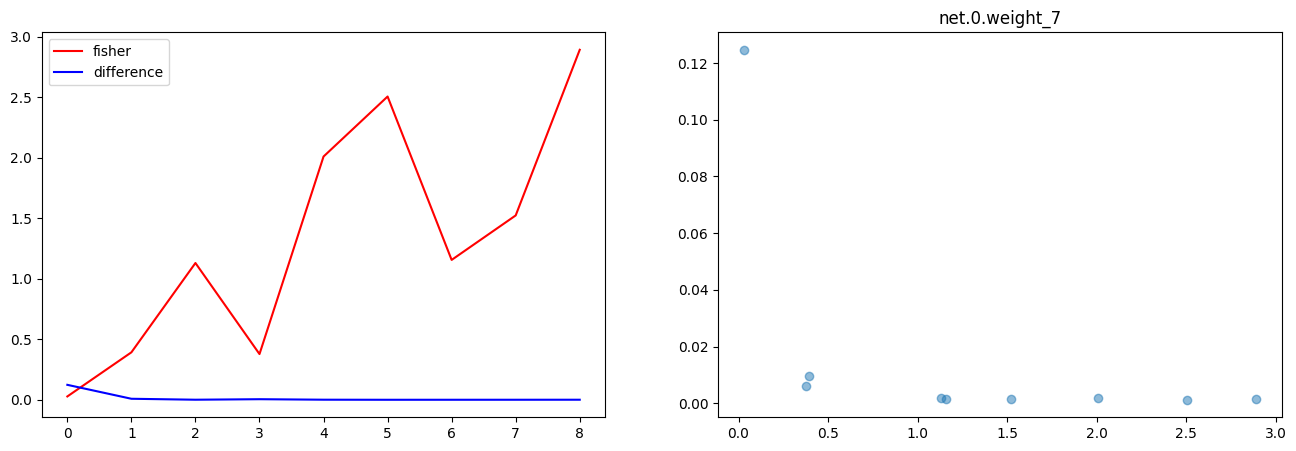

Max fisher is 0.32337 and it's parameter diff is 0.00779
Min Parameter diff is 0.43173 and it's fisher is 0.00134
fisher > parameter diff: 5
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

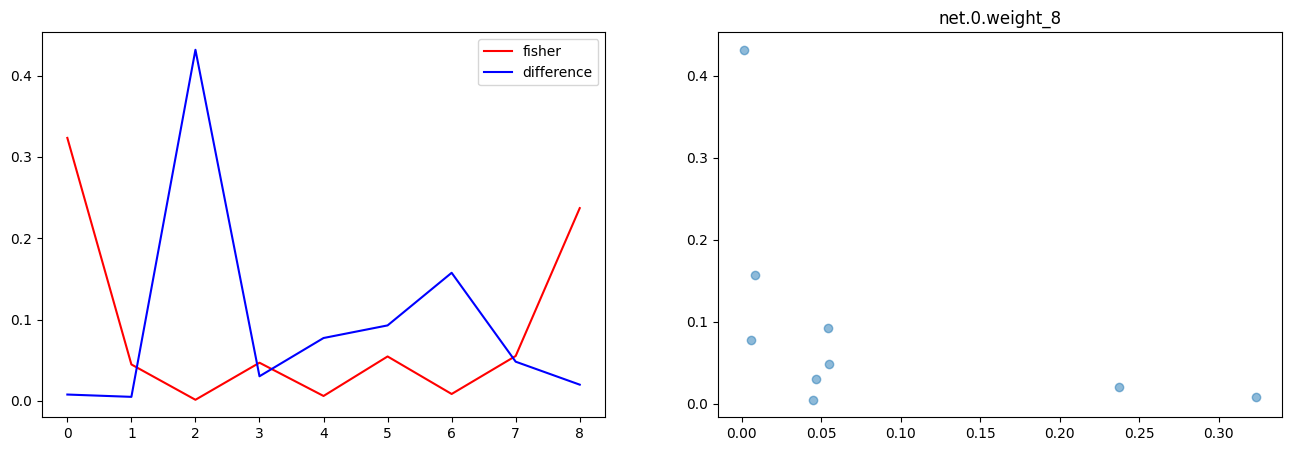

Max fisher is 0.76017 and it's parameter diff is 0.00133
Min Parameter diff is 0.03085 and it's fisher is 0.20597
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

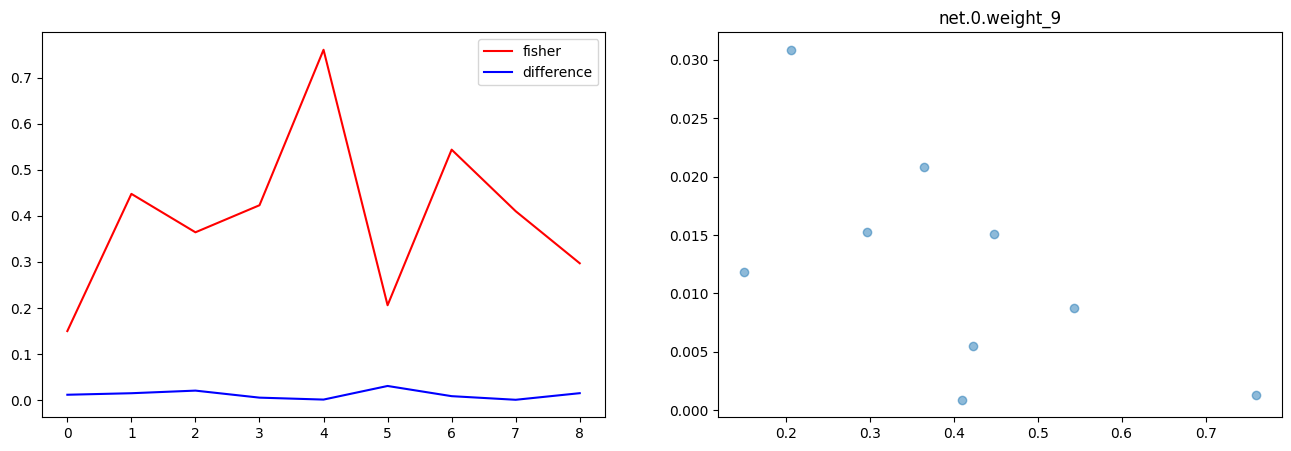


net.0.bias
torch.Size([10])
Max fisher is 7.11855 and it's parameter diff is 0.00000
Min Parameter diff is 0.16710 and it's fisher is 0.00000
fisher > parameter diff: 4
fisher <= parameter diff: 6


<Figure size 640x480 with 0 Axes>

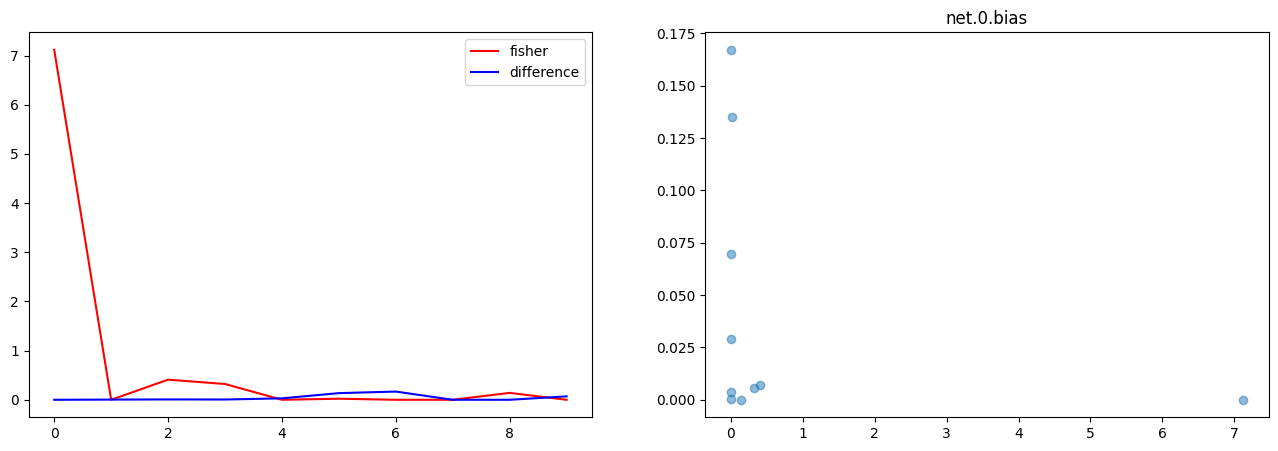


net.3.weight
torch.Size([10])
Max fisher is 0.56143 and it's parameter diff is 0.00234
Min Parameter diff is 0.04671 and it's fisher is 0.09440
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

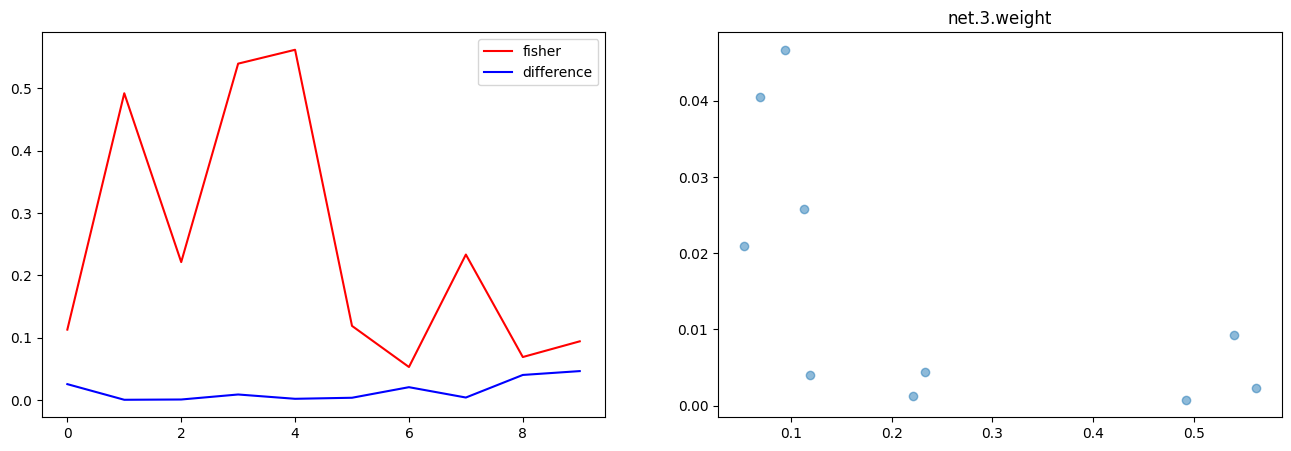


net.3.bias
torch.Size([10])
Max fisher is 0.10670 and it's parameter diff is 0.00204
Min Parameter diff is 0.47204 and it's fisher is 0.00091
fisher > parameter diff: 4
fisher <= parameter diff: 6


<Figure size 640x480 with 0 Axes>

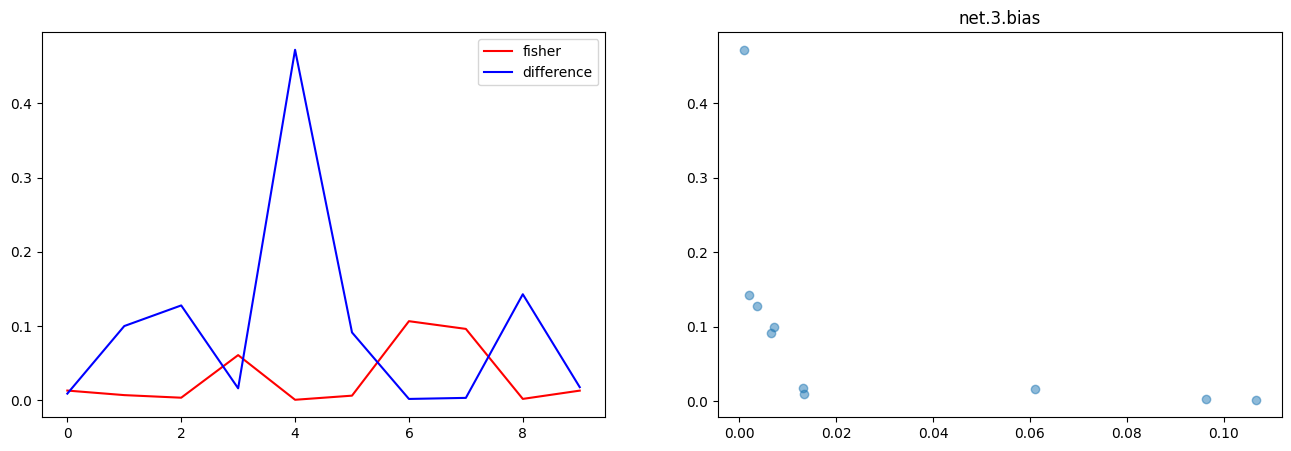


net.4.weight
torch.Size([5, 10, 3, 3])
Max fisher is 4.87327 and it's parameter diff is 0.00020
Min Parameter diff is 0.17097 and it's fisher is 0.01033
fisher > parameter diff: 81
fisher <= parameter diff: 9


<Figure size 640x480 with 0 Axes>

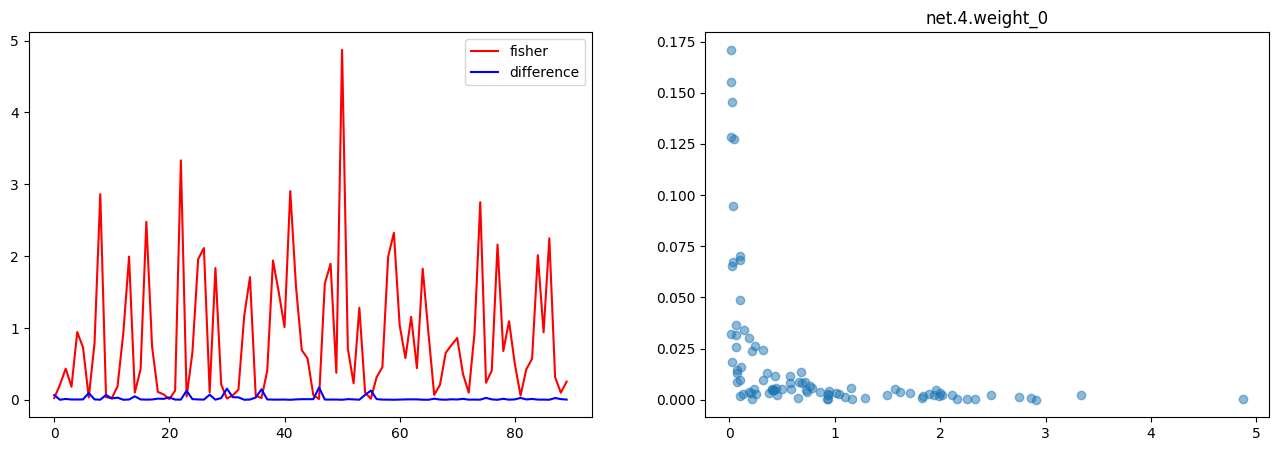

Max fisher is 8.28171 and it's parameter diff is 0.00067
Min Parameter diff is 0.13881 and it's fisher is 0.02691
fisher > parameter diff: 77
fisher <= parameter diff: 13


<Figure size 640x480 with 0 Axes>

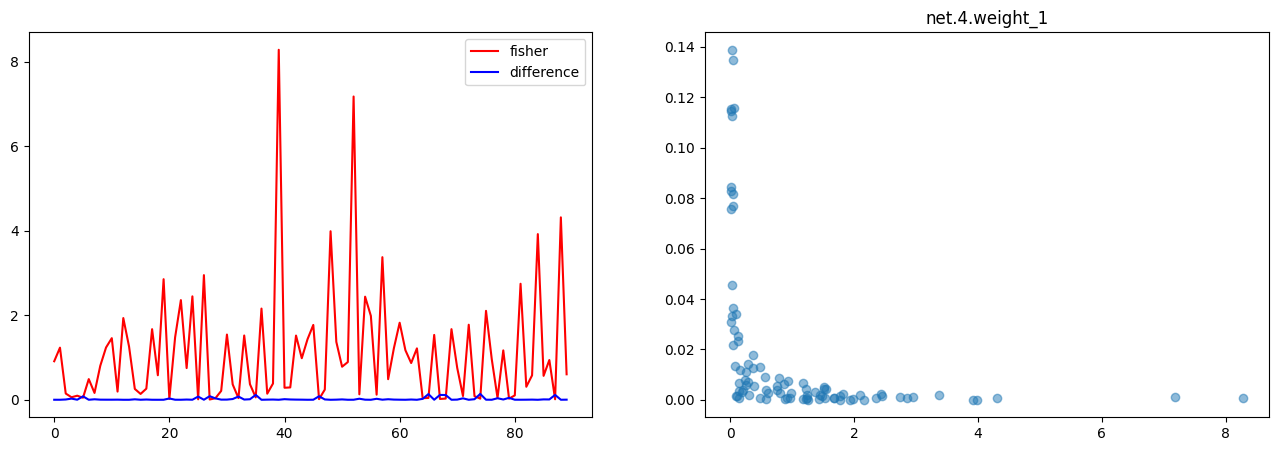

Max fisher is 3.50945 and it's parameter diff is 0.00134
Min Parameter diff is 0.09851 and it's fisher is 0.02885
fisher > parameter diff: 84
fisher <= parameter diff: 6


<Figure size 640x480 with 0 Axes>

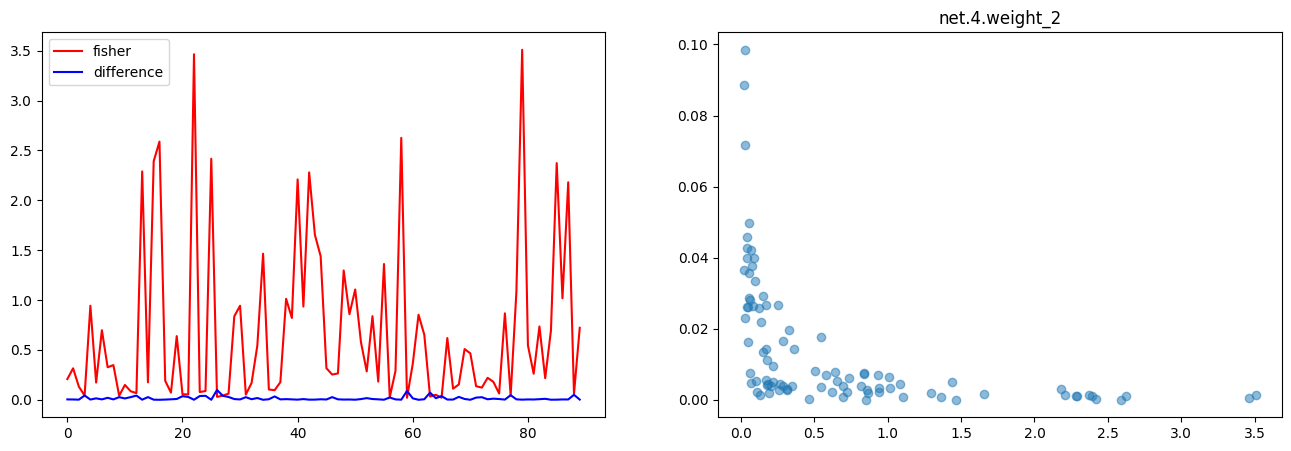

Max fisher is 0.74189 and it's parameter diff is 0.00062
Min Parameter diff is 0.24586 and it's fisher is 0.00376
fisher > parameter diff: 63
fisher <= parameter diff: 27


<Figure size 640x480 with 0 Axes>

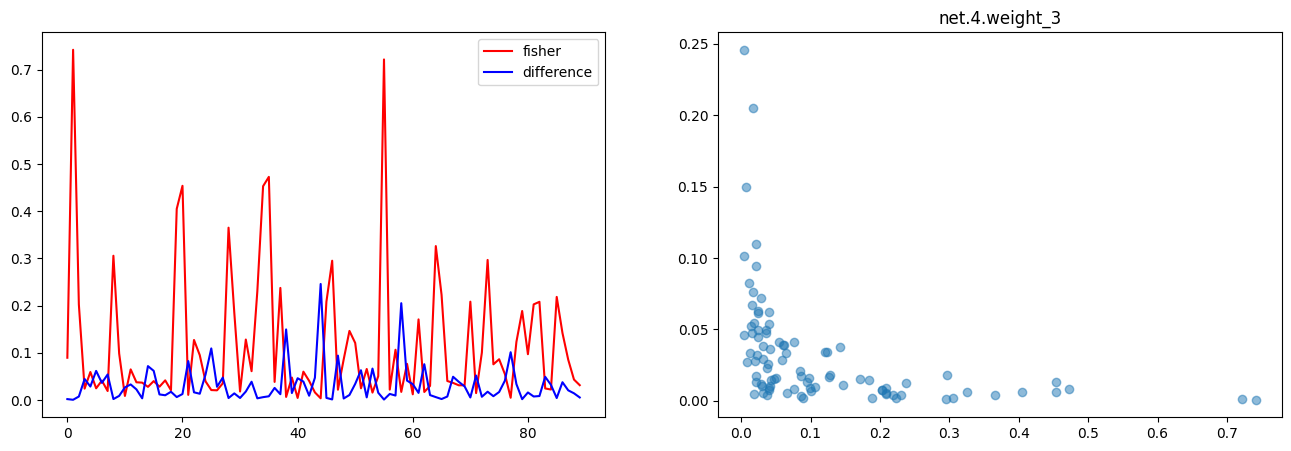

Max fisher is 4.30166 and it's parameter diff is 0.00098
Min Parameter diff is 0.11536 and it's fisher is 0.02678
fisher > parameter diff: 86
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

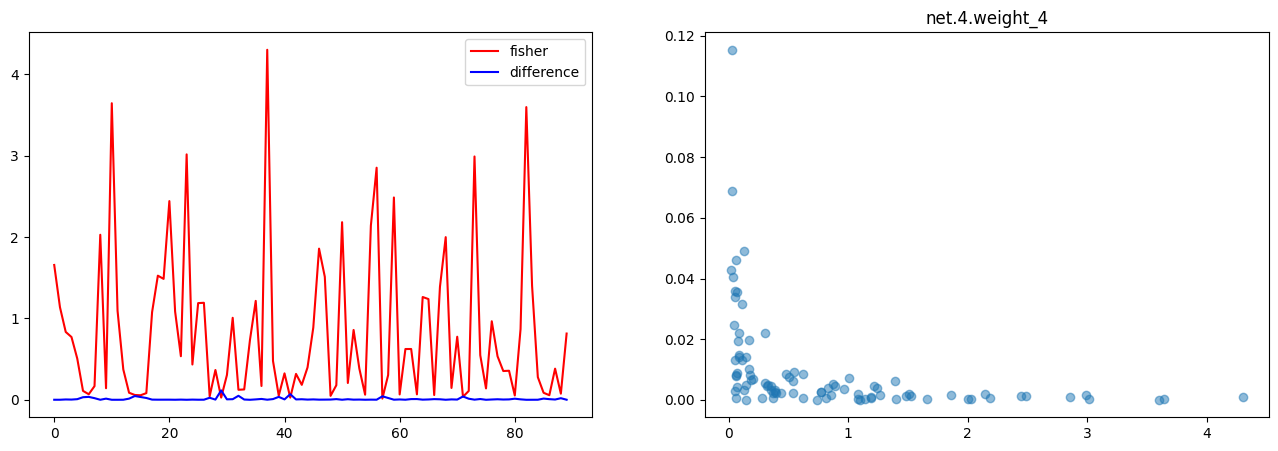


net.4.bias
torch.Size([5])
Max fisher is 0.00000 and it's parameter diff is 0.00070
Min Parameter diff is 0.14484 and it's fisher is 0.00000
fisher > parameter diff: 0
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

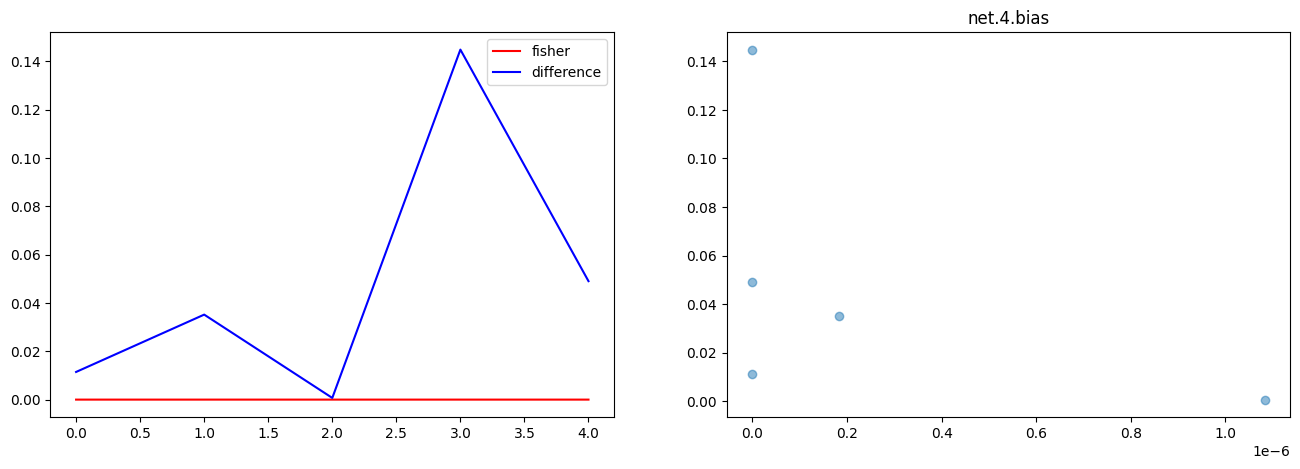


net.7.weight
torch.Size([5])
Max fisher is 0.48326 and it's parameter diff is 0.00009
Min Parameter diff is 0.04964 and it's fisher is 0.04008
fisher > parameter diff: 4
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

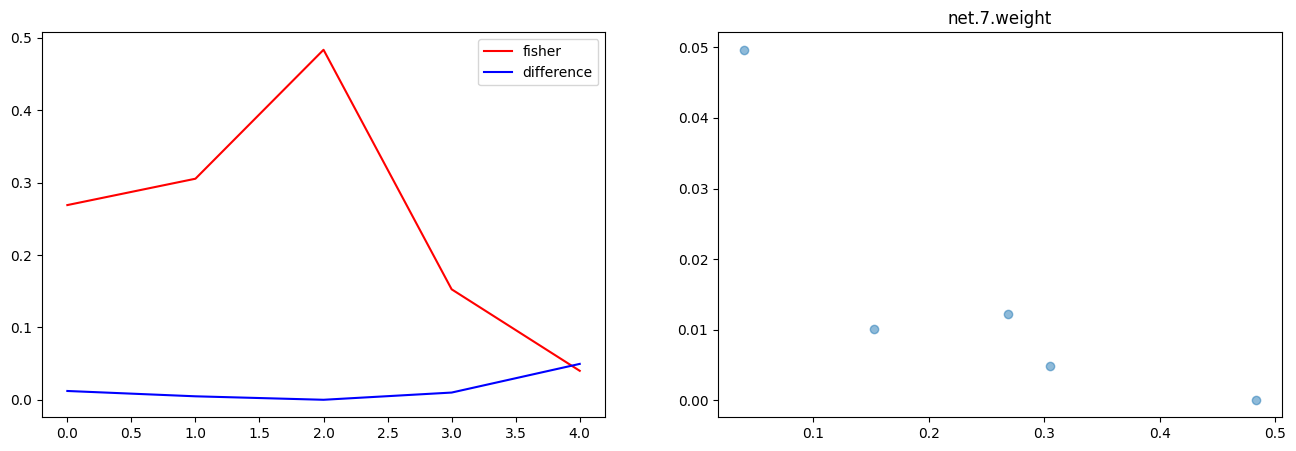


net.7.bias
torch.Size([5])
Max fisher is 0.11238 and it's parameter diff is 0.00391
Min Parameter diff is 0.03100 and it's fisher is 0.02493
fisher > parameter diff: 3
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

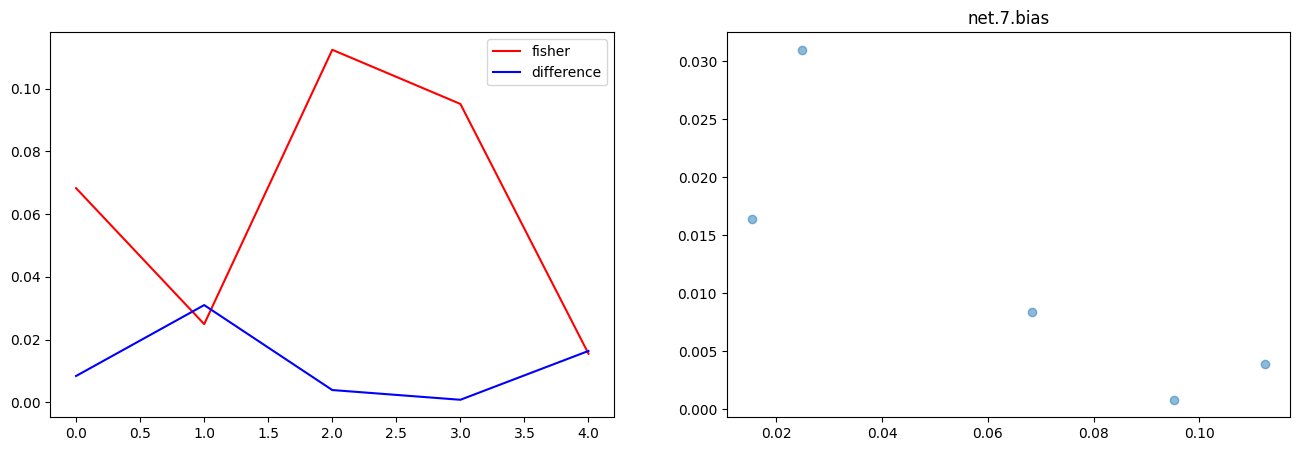


net.9.weight
torch.Size([10, 20])
Max fisher is 0.07634 and it's parameter diff is 0.00503
Min Parameter diff is 0.41812 and it's fisher is 0.00193
fisher > parameter diff: 4
fisher <= parameter diff: 16


<Figure size 640x480 with 0 Axes>

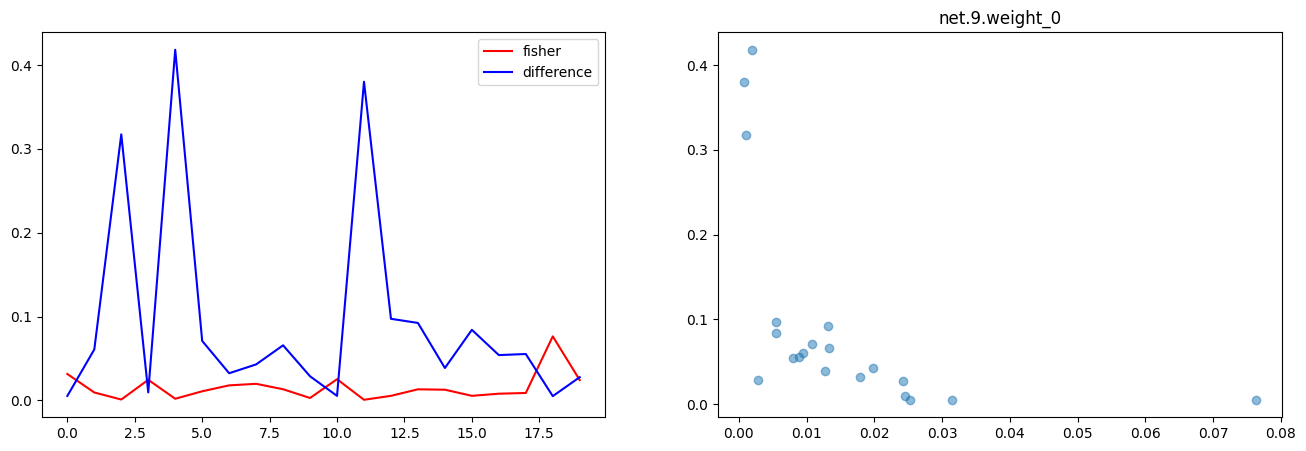

Max fisher is 0.09120 and it's parameter diff is 0.01791
Min Parameter diff is 0.38656 and it's fisher is 0.00368
fisher > parameter diff: 6
fisher <= parameter diff: 14


<Figure size 640x480 with 0 Axes>

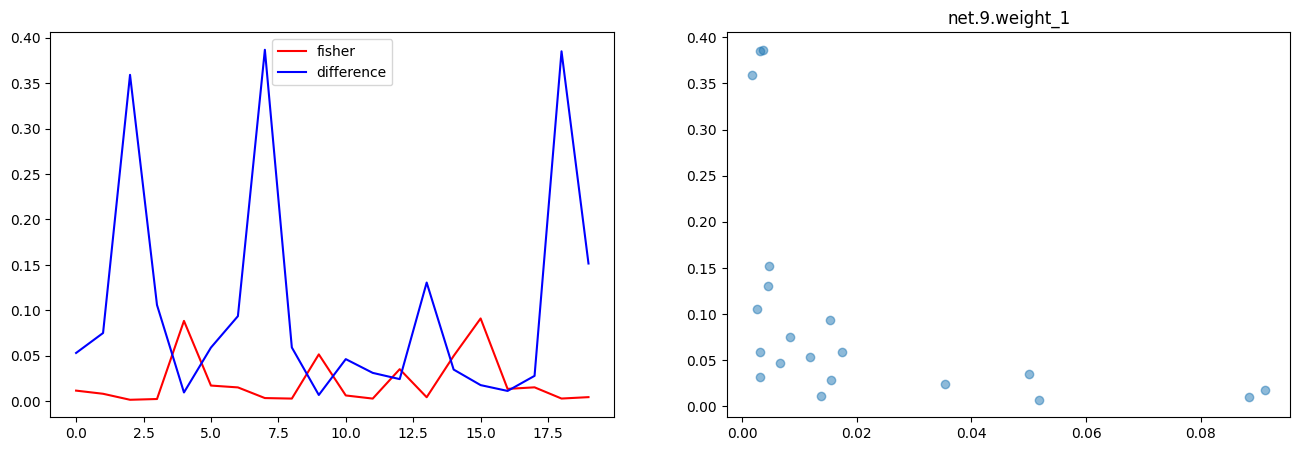

Max fisher is 0.13151 and it's parameter diff is 0.00218
Min Parameter diff is 0.67902 and it's fisher is 0.00102
fisher > parameter diff: 12
fisher <= parameter diff: 8


<Figure size 640x480 with 0 Axes>

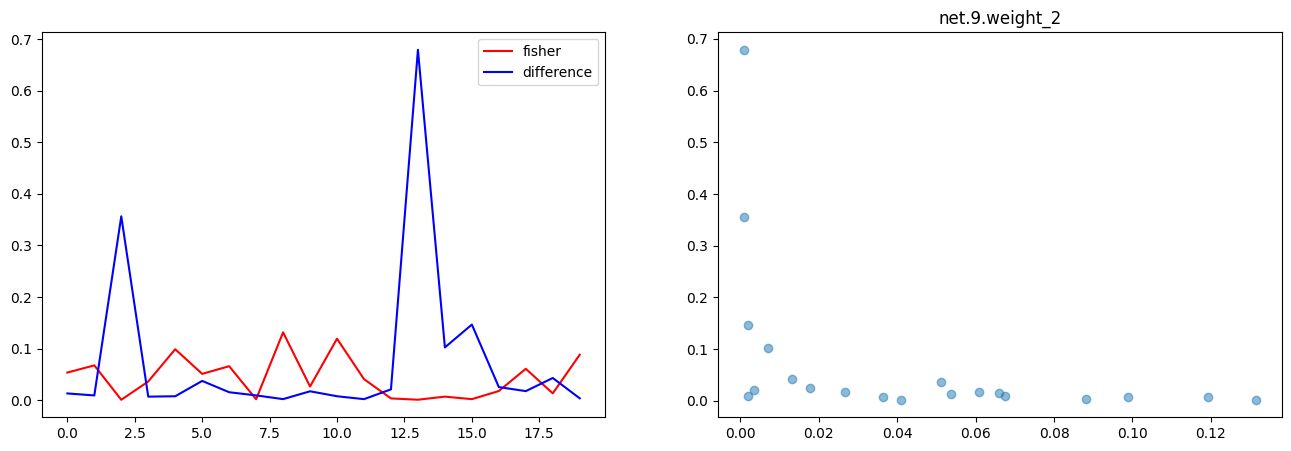

Max fisher is 0.07639 and it's parameter diff is 0.02529
Min Parameter diff is 0.70688 and it's fisher is 0.00080
fisher > parameter diff: 8
fisher <= parameter diff: 12


<Figure size 640x480 with 0 Axes>

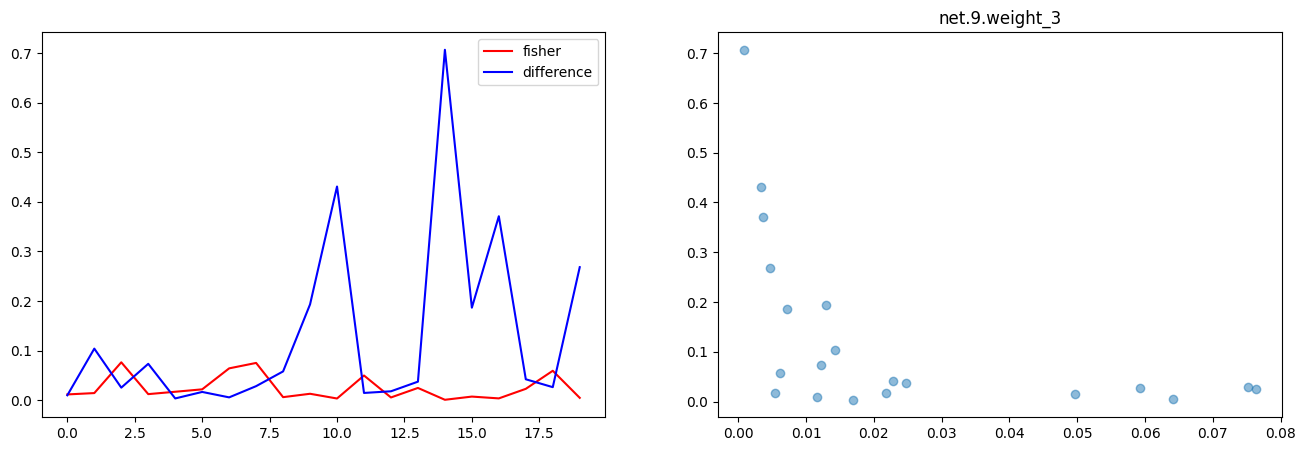

Max fisher is 0.14457 and it's parameter diff is 0.00699
Min Parameter diff is 0.79435 and it's fisher is 0.00034
fisher > parameter diff: 9
fisher <= parameter diff: 11


<Figure size 640x480 with 0 Axes>

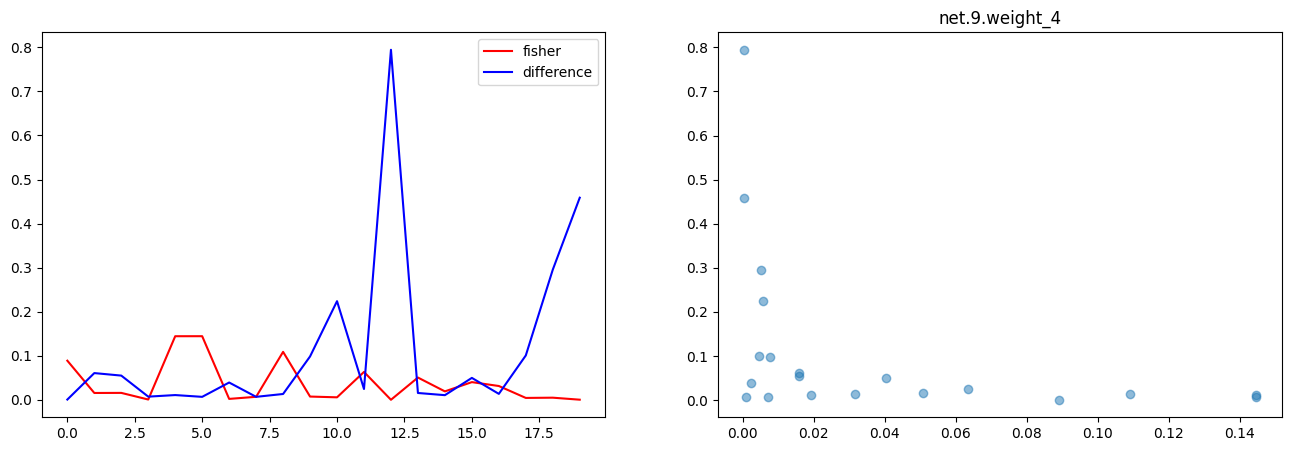

Max fisher is 0.50527 and it's parameter diff is 0.00063
Min Parameter diff is 0.44704 and it's fisher is 0.00370
fisher > parameter diff: 12
fisher <= parameter diff: 8


<Figure size 640x480 with 0 Axes>

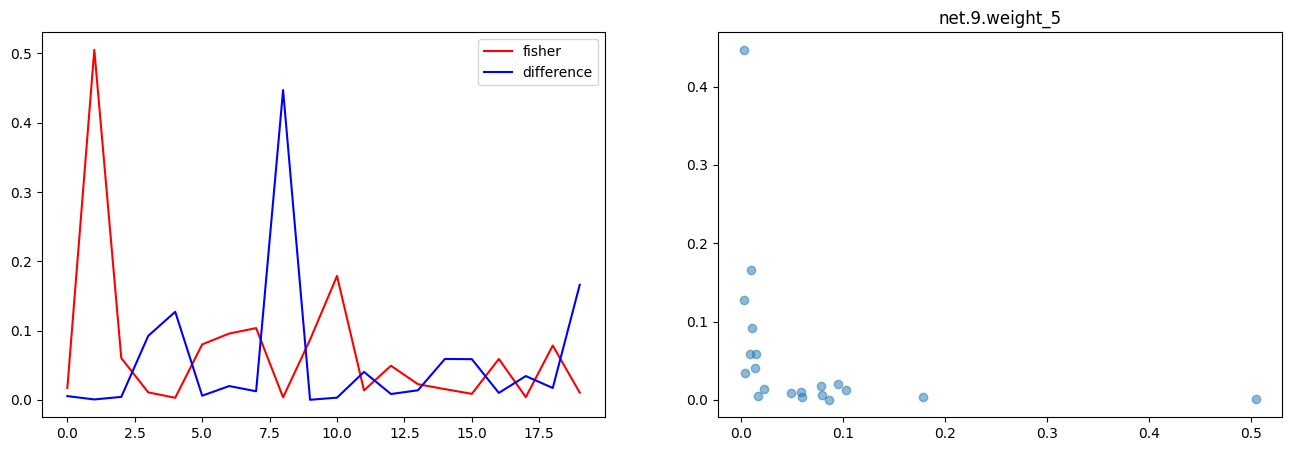

Max fisher is 0.25580 and it's parameter diff is 0.00277
Min Parameter diff is 0.46897 and it's fisher is 0.00124
fisher > parameter diff: 7
fisher <= parameter diff: 13


<Figure size 640x480 with 0 Axes>

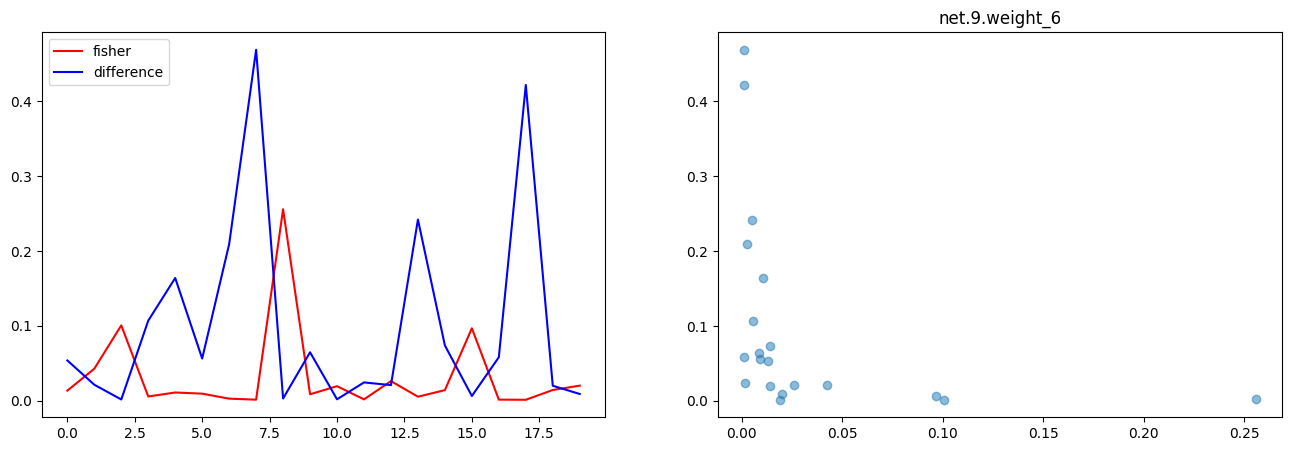

Max fisher is 0.17122 and it's parameter diff is 0.00742
Min Parameter diff is 0.32029 and it's fisher is 0.00291
fisher > parameter diff: 8
fisher <= parameter diff: 12


<Figure size 640x480 with 0 Axes>

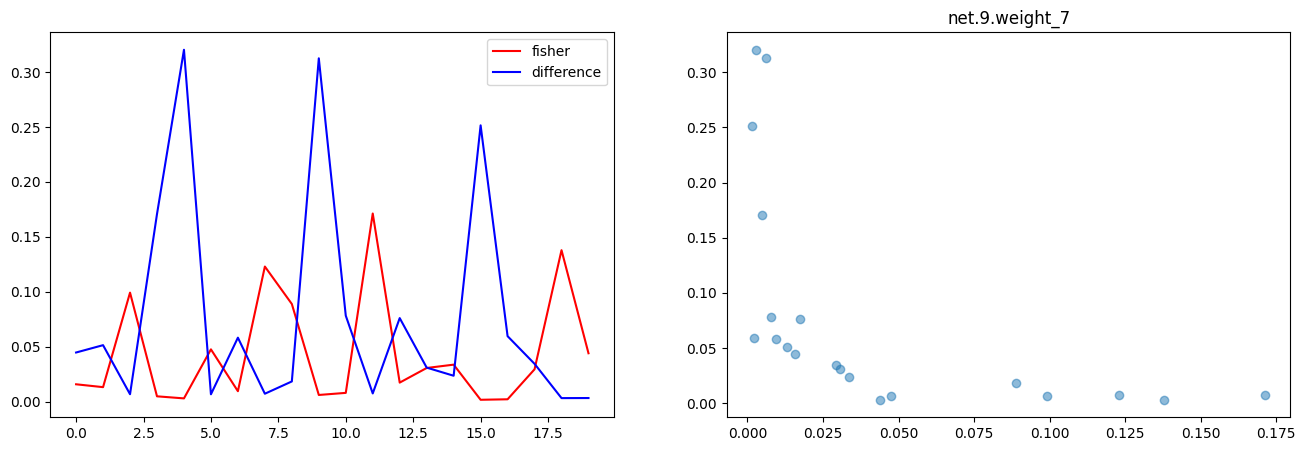

Max fisher is 0.38011 and it's parameter diff is 0.00443
Min Parameter diff is 0.69026 and it's fisher is 0.00284
fisher > parameter diff: 14
fisher <= parameter diff: 6


<Figure size 640x480 with 0 Axes>

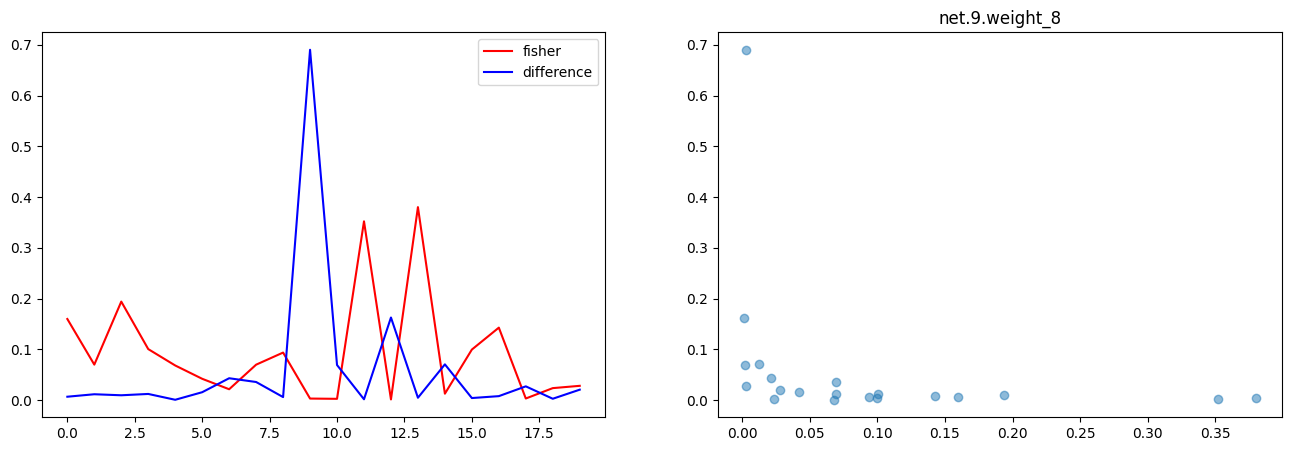

Max fisher is 0.31567 and it's parameter diff is 0.00160
Min Parameter diff is 0.21876 and it's fisher is 0.00279
fisher > parameter diff: 15
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

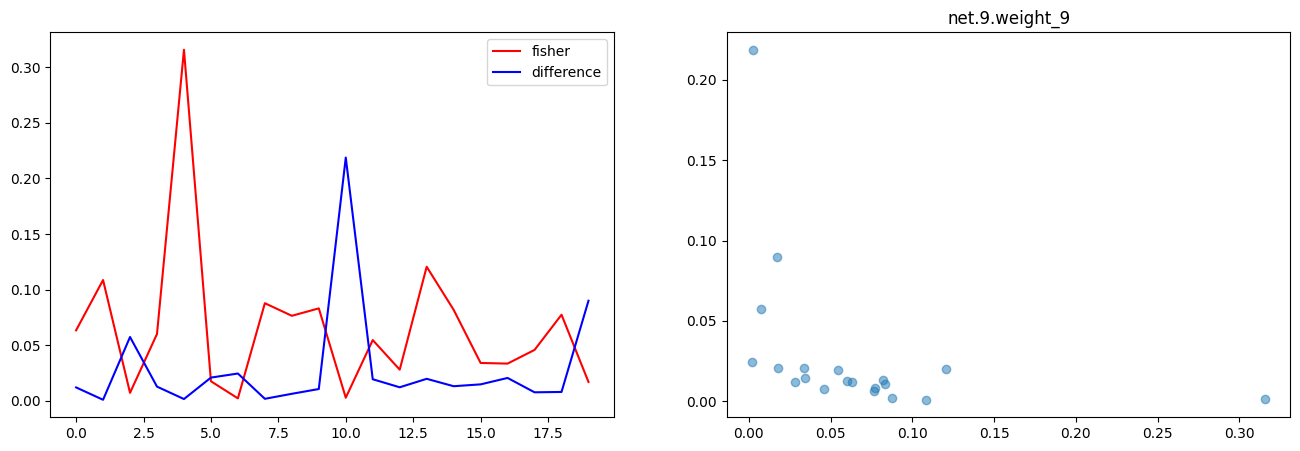


net.9.bias
torch.Size([10])
Max fisher is 0.07934 and it's parameter diff is 0.00218
Min Parameter diff is 0.13957 and it's fisher is 0.00395
fisher > parameter diff: 6
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

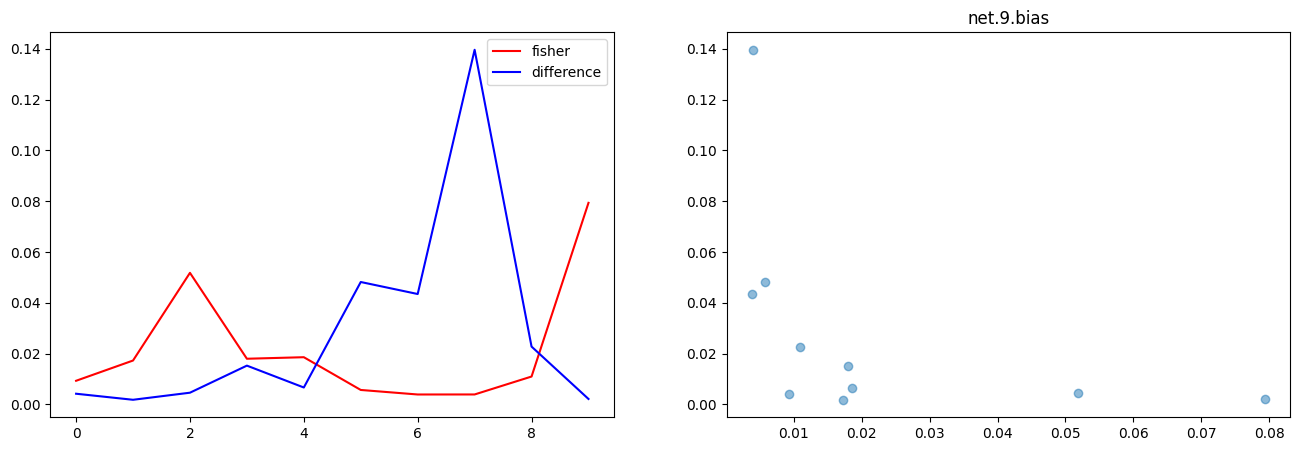

In [83]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i].flatten(), optim_para[0][name][i].flatten(), param[i].flatten(), f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [84]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-25_22_02_04
